In [1]:
%matplotlib inline
import pandas as pd
import matplotlib as mt
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
from numpy import concatenate
from keras.utils import to_categorical
from math import sqrt

Using TensorFlow backend.


In [58]:
df = pd.read_csv('/Users/renaudleurquin/Documents/TSP/2A/Cassiopé/BDD/FDAX_indicateurs.txt', sep='\t', skipinitialspace=True)
#skipinitialspace permet de retirer les espaces génants sur les colonnes et sur les données

#suppression des colonnes non utiles à la prédiction
colonnes = ['# of Trades','OHLC Avg', 'HLC Avg', 'Volume', 'HL Avg', 'Bid Volume', 'Ask Volume', 'Open.1','High.1', 'Low.1', "etat variable 'Volume'", 'Close',"etat variable 'DeltaSpread'", "etat variable 'PriceChange'","etat variable 'Delta'", 'volume', 'deltaSpread', 'priceChange','delta', "etat variable 'spread'", "etat variable 'open'","etat variable 'close'", "etat variable 'deltaOpen'","etat variable 'deltaClose'", 'weak', 'strong', 'Strong Triangle','weak Triangle', 'delta_sos', 'delta_sow','Signal de vente', 'trendFilter']
df.drop(colonnes, axis = 1, inplace = True)

df['Date&Time'] = df['Date'] +' '+ df['Time']
df['date_time'] = pd.to_datetime(df['Date&Time'], format='%d/%m/%Y %H:%M:%S.%f')
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S.%f')
df.drop(['Date', 'Date&Time'], axis=1, inplace=True)
df = df[['date_time', 'Time', 'Open', 'High', 'Low', 'Last', "Signal d'achat"]]
df

,date_time,Time,Open,High,Low,Last,Signal d'achat
0,2013-01-04 08:00:00,1900-01-01 08:00:00,7842.0,7844.5,7839.5,7840.5,0.0
1,2013-01-04 08:05:00,1900-01-01 08:05:00,7840.0,7842.0,7837.0,7838.0,0.0
2,2013-01-04 08:10:00,1900-01-01 08:10:00,7837.5,7837.5,7833.0,7836.5,0.0
3,2013-01-04 08:15:00,1900-01-01 08:15:00,7836.5,7840.0,7835.5,7839.5,0.0
4,2013-01-04 08:20:00,1900-01-01 08:20:00,7840.0,7840.0,7837.0,7837.0,0.0
...,...,...,...,...,...,...,...
296602,2019-12-11 21:40:00,1900-01-01 21:40:00,13144.5,13150.0,13144.0,13149.5,0.0
296603,2019-12-11 21:45:00,1900-01-01 21:45:00,13150.0,13153.0,13143.0,13144.5,0.0
296604,2019-12-11 21:50:00,1900-01-01 21:50:00,13145.0,13155.0,13145.0,13154.5,0.0
296605,2019-12-11 21:55:00,1900-01-01 21:55:00,13153.0,13154.0,13147.5,13151.0,0.0


In [3]:
df['Spread'] = df['High'] - df['Low']
df = df.reindex(columns=['date_time', 'Time', 'Open', 'High', 'Low', 'Spread', 'Last'])
df

,date_time,Time,Open,High,Low,Spread,Last
0,2013-01-04 08:00:00,1900-01-01 08:00:00,7842.0,7844.5,7839.5,5.0,7840.5
1,2013-01-04 08:05:00,1900-01-01 08:05:00,7840.0,7842.0,7837.0,5.0,7838.0
2,2013-01-04 08:10:00,1900-01-01 08:10:00,7837.5,7837.5,7833.0,4.5,7836.5
3,2013-01-04 08:15:00,1900-01-01 08:15:00,7836.5,7840.0,7835.5,4.5,7839.5
4,2013-01-04 08:20:00,1900-01-01 08:20:00,7840.0,7840.0,7837.0,3.0,7837.0
...,...,...,...,...,...,...,...
296602,2019-12-11 21:40:00,1900-01-01 21:40:00,13144.5,13150.0,13144.0,6.0,13149.5
296603,2019-12-11 21:45:00,1900-01-01 21:45:00,13150.0,13153.0,13143.0,10.0,13144.5
296604,2019-12-11 21:50:00,1900-01-01 21:50:00,13145.0,13155.0,13145.0,10.0,13154.5
296605,2019-12-11 21:55:00,1900-01-01 21:55:00,13153.0,13154.0,13147.5,6.5,13151.0


In [4]:
Y=[]
n = df.shape[0]
for i in range (1,n) : 
    if df.iloc[i,5]<df.iloc[i-1,5]:
        Y.append(-1)
    if df.iloc[i,5]==df.iloc[i-1,5]:
        Y.append(0)
    if df.iloc[i,5]>df.iloc[i-1,5]:
        Y.append(1) 

In [5]:
df = df.iloc[1:,:]
df.insert(7,'Y',Y)

date_limite = dt.datetime.strptime('2014-01-01 08:00:00.0', '%Y-%m-%d %H:%M:%S.%f')
dix_huit = dt.datetime.strptime('18:05:00.0', '%H:%M:%S.%f')

df_2013 = df.loc[(df["date_time"]<date_limite) & (df["Time"]<dix_huit)]

df_2013

,date_time,Time,Open,High,Low,Spread,Last,Y
1,2013-01-04 08:05:00,1900-01-01 08:05:00,7840.0,7842.0,7837.0,5.0,7838.0,0
2,2013-01-04 08:10:00,1900-01-01 08:10:00,7837.5,7837.5,7833.0,4.5,7836.5,-1
3,2013-01-04 08:15:00,1900-01-01 08:15:00,7836.5,7840.0,7835.5,4.5,7839.5,0
4,2013-01-04 08:20:00,1900-01-01 08:20:00,7840.0,7840.0,7837.0,3.0,7837.0,-1
5,2013-01-04 08:25:00,1900-01-01 08:25:00,7837.0,7842.5,7836.5,6.0,7840.5,1
...,...,...,...,...,...,...,...,...
42248,2013-12-30 17:40:00,1900-01-01 17:40:00,9651.5,9654.0,9650.5,3.5,9652.5,-1
42249,2013-12-30 17:45:00,1900-01-01 17:45:00,9652.0,9659.0,9652.0,7.0,9655.5,1
42250,2013-12-30 17:50:00,1900-01-01 17:50:00,9655.5,9658.5,9654.5,4.0,9658.0,-1
42251,2013-12-30 17:55:00,1900-01-01 17:55:00,9658.0,9658.5,9655.0,3.5,9658.0,-1


In [6]:
#Il est nécessaire de changer l'index du dataframe pour le pre-processing des données
index = np.linspace(1,30264, num=30264, dtype='int64')
df_2013.index = index
df_2013.tail(10)

,date_time,Time,Open,High,Low,Spread,Last,Y
30255,2013-12-30 17:15:00,1900-01-01 17:15:00,9660.0,9664.5,9659.0,5.5,9661.0,-1
30256,2013-12-30 17:20:00,1900-01-01 17:20:00,9661.0,9662.0,9654.5,7.5,9655.0,1
30257,2013-12-30 17:25:00,1900-01-01 17:25:00,9655.5,9658.0,9648.5,9.5,9656.5,1
30258,2013-12-30 17:30:00,1900-01-01 17:30:00,9656.5,9662.5,9647.0,15.5,9648.5,1
30259,2013-12-30 17:35:00,1900-01-01 17:35:00,9647.5,9655.0,9647.0,8.0,9652.0,-1
30260,2013-12-30 17:40:00,1900-01-01 17:40:00,9651.5,9654.0,9650.5,3.5,9652.5,-1
30261,2013-12-30 17:45:00,1900-01-01 17:45:00,9652.0,9659.0,9652.0,7.0,9655.5,1
30262,2013-12-30 17:50:00,1900-01-01 17:50:00,9655.5,9658.5,9654.5,4.0,9658.0,-1
30263,2013-12-30 17:55:00,1900-01-01 17:55:00,9658.0,9658.5,9655.0,3.5,9658.0,-1
30264,2013-12-30 18:00:00,1900-01-01 18:00:00,9657.5,9659.5,9656.5,3.0,9657.0,-1


In [7]:
import sklearn
from sklearn.preprocessing import MinMaxScaler

In [8]:
#On exclut la date et l'heure qui ne sont pas des données d'apprentissage et les labels
n = df_2013.shape[0]
limit = int(4*n/5)
values_app = df_2013.iloc[:limit,2:7].values

#Processus de normalisation à partir des données d'apprentissage
scaler = MinMaxScaler(feature_range=(0,1))
scaler = scaler.fit(values_app)

#Normalisation de l'ensemble des données à partir du modèle de normalisation construit sur les données d'apprentissage
values = df_2013.iloc[:,2:7]
normalized = scaler.transform(values)
processed_data = pd.DataFrame(normalized)
colonnes = ['Open', 'High', 'Low', 'Spread', 'Last']
processed_data.columns = colonnes

#J'ai mis tellement de temps à comprendre ce souci 
processed_data.index = processed_data.index+1 #car pour ajouter la colonne Y dans ce nouveau df, il faut que les indices correspondent
processed_data['Y'] = df_2013['Y']
values_processed = processed_data.values #numpy representation des données
processed_data

,Open,High,Low,Spread,Last,Y
1,0.230439,0.229433,0.237522,0.046296,0.229286,0
2,0.228653,0.226241,0.234690,0.041667,0.228214,-1
3,0.227939,0.228014,0.236460,0.041667,0.230357,0
4,0.230439,0.228014,0.237522,0.027778,0.228571,-1
5,0.228296,0.229787,0.237168,0.055556,0.231071,1
...,...,...,...,...,...,...
30260,1.524830,1.514539,1.521416,0.032407,1.525357,-1
30261,1.525188,1.518085,1.522478,0.064815,1.527500,1
30262,1.527688,1.517730,1.524248,0.037037,1.529286,-1
30263,1.529475,1.517730,1.524602,0.032407,1.529286,-1


In [9]:
#Données d'apprentissage
X_train = values_processed[:limit,:4]
Y_train = values_processed[:limit,4]

#Données de test
X_test = values_processed[limit:,:4]
Y_test = values_processed[limit:,4]

print("Minimum value is %s" %(normalized.min()) )
print("Maximum value is %s" %(normalized.max()) )
print("======================================")
print()
print(X_train.shape[0], ' : number of train samples')
print(X_test.shape[0], ' : number of test samples')
print('X_train shape: ', X_train.shape)
print('Y_train shape: ', Y_train.shape)
print('X_test shape: ', X_test.shape)
print('Y_test shape: ', Y_test.shape)

Minimum value is 0.0
Maximum value is 1.531618435155413

24211  : number of train samples
6053  : number of test samples
X_train shape:  (24211, 4)
Y_train shape:  (24211,)
X_test shape:  (6053, 4)
Y_test shape:  (6053,)


In [10]:
import keras 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import LSTM
from keras import activations
from keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error

In [11]:
def build_dataset(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [12]:
scaled = normalized
time_lag = 2
data_set_lstm = build_dataset(scaled, time_lag)
data_set_lstm.head(10)

,var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var2(t),var3(t),var4(t),var5(t)
2,0.230439,0.229433,0.237522,0.046296,0.229286,0.228653,0.226241,0.234690,0.041667,0.228214,0.227939,0.228014,0.236460,0.041667,0.230357
3,0.228653,0.226241,0.234690,0.041667,0.228214,0.227939,0.228014,0.236460,0.041667,0.230357,0.230439,0.228014,0.237522,0.027778,0.228571
4,0.227939,0.228014,0.236460,0.041667,0.230357,0.230439,0.228014,0.237522,0.027778,0.228571,0.228296,0.229787,0.237168,0.055556,0.231071
5,0.230439,0.228014,0.237522,0.027778,0.228571,0.228296,0.229787,0.237168,0.055556,0.231071,0.230797,0.229078,0.238938,0.023148,0.230714
6,0.228296,0.229787,0.237168,0.055556,0.231071,0.230797,0.229078,0.238938,0.023148,0.230714,0.230439,0.228723,0.238938,0.018519,0.230714
7,0.230797,0.229078,0.238938,0.023148,0.230714,0.230439,0.228723,0.238938,0.018519,0.230714,0.230439,0.228723,0.238230,0.027778,0.230714
8,0.230439,0.228723,0.238938,0.018519,0.230714,0.230439,0.228723,0.238230,0.027778,0.230714,0.230439,0.229787,0.238938,0.032407,0.232500
9,0.230439,0.228723,0.238230,0.027778,0.230714,0.230439,0.229787,0.238938,0.032407,0.232500,0.231869,0.230851,0.239646,0.037037,0.232857
10,0.230439,0.229787,0.238938,0.032407,0.232500,0.231869,0.230851,0.239646,0.037037,0.232857,0.232583,0.230851,0.238584,0.050926,0.231786
11,0.231869,0.230851,0.239646,0.037037,0.232857,0.232583,0.230851,0.238584,0.050926,0.231786,0.232226,0.230496,0.235752,0.083333,0.228214


In [13]:
def data_new (time_lag): #time_lag = parameter to design how many time steps to consider in the input data 
    ndrop=time_lag*5
    scaled = normalized
    processed_data_lstm = build_dataset(scaled, time_lag, 1)
    processed_data_lstm.drop(columns = processed_data_lstm.columns[[ndrop, ndrop+1, ndrop+2, ndrop+3]], inplace=True)
    
    # split into train and test sets
    values = processed_data_lstm.values  #values is a numpy representation of processed_data, which is data normalized for prediction
    train = values[:limit, :]
    test = values[limit:, :]
    
    # split into input and outputs
    X_train_lstm, Y_train_lstm = train[:, :-1], train[:, -1] #train_X takes all columns minus the last one which stands for the value of the Last
    X_test_lstm, Y_test_lstm = test[:, :-1], test[:, -1]
    
    # reshape input to be 3D [samples, timesteps, features]
    X_train_lstm = X_train_lstm.reshape((X_train_lstm.shape[0], 1, X_train_lstm.shape[1]))
    X_test_lstm = X_test_lstm.reshape((X_test_lstm.shape[0], 1, X_test_lstm.shape[1]))
    return(X_train_lstm, Y_train_lstm, X_test_lstm, Y_test_lstm)  

In [14]:
def optimal_model_2_layers():
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(loss = 'mse', 
                 optimizer='adam', 
                 metrics=['accuracy'])
    return(model)

In [15]:
train_X, train_y, test_X, test_y = data_new(2)
model_lstm = optimal_model_2_layers()
model_lstm.fit(train_X, train_y, epochs=200, batch_size=64, validation_data=(test_X, test_y), verbose=0)

In [16]:
def prediction (train_X, train_y, test_X, test_y, model):
    # faire la prediction
    yhat = model.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

    # inverser le scaling pour les données prédites
    inv_yhat = concatenate((yhat, test_X[:,:4]), axis=1) #concatenation column-wise
    inv_yhat = scaler.inverse_transform(inv_yhat) #the values were scaled before putting them into the neural networks, this operation makes the inverse operation so that the values are comprehensible
    inv_yhat = inv_yhat[:,0]

    # inverser le scaling pour les vraies valeurs 
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = concatenate((test_y, test_X[:,:4]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]

    #liste des valeurs du Low
    val_low_test = df_2013.iloc[limit+2:,4].values

    #liste des valeurs du High
    val_high_test = df_2013.iloc[limit+2:,3].values
    
    return(inv_yhat, inv_y, val_low_test, val_high_test)


def tracer_prediction_no_date(nb_points, inv_yhat, inv_y, val_low_test, val_high_test):  #nb_points est le nombre de points considérés
    plt.figure(figsize=(15, 9))
    x=np.linspace(1,nb_points,nb_points)
    plt.plot(x, inv_yhat[1:nb_points+1], 'r', lw=1.5, label='Prediction')
    plt.plot(x, inv_y[:nb_points], 'b', lw=1.5, label='Valeur réelle')
    plt.plot(x, val_low_test[:nb_points], 'k--', lw=1, label='Low')
    plt.plot(x, val_high_test[:nb_points], 'k--', lw=1, label='High')
    plt.fill_between(x, val_low_test[:nb_points], val_high_test[:nb_points], color='0.7')
    plt.legend(fontsize=14)
    plt.title('Comparaison entre les valeurs réelles et prédites par notre modèle', fontsize=16)
    plt.xlabel('Date et heure', fontsize=14)
    plt.ylabel('Valeur du Last', fontsize=14)
    plt.tight_layout()

In [17]:
prediction, reel, low, high = prediction(train_X, train_y, test_X, test_y, model_lstm)

In [18]:
print(df_2013.iloc[limit+2:,:].shape[0])
print(len(reel))
print(len(prediction))

6051
6051
6051


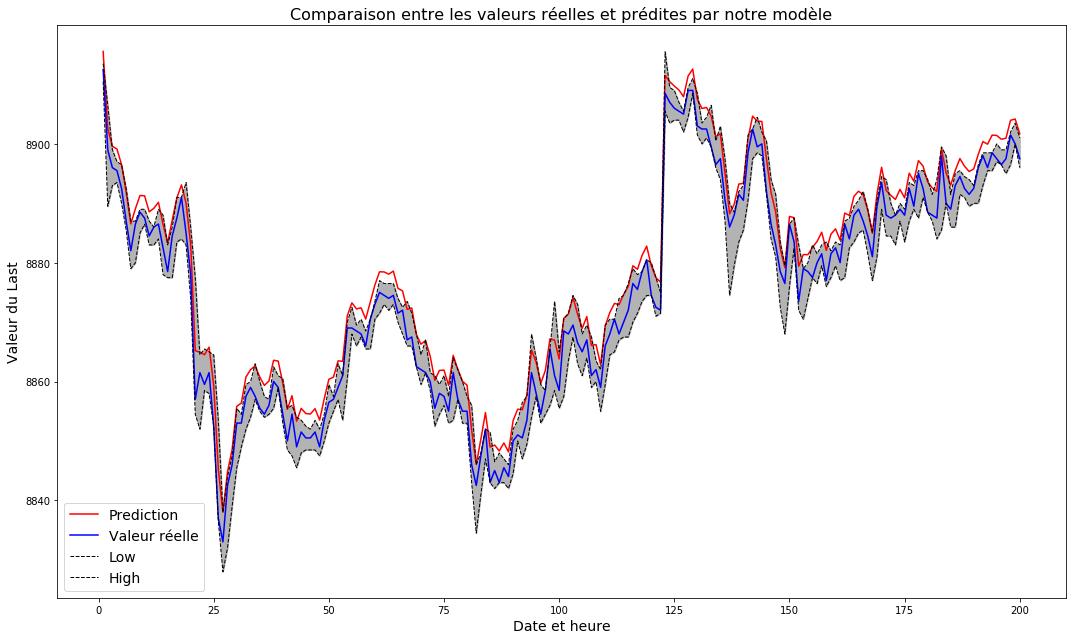

In [26]:
tracer_prediction_no_date(200,prediction,reel,low,high)

In [27]:
#Calcul de la RMSE
rmse = sqrt(mean_squared_error(prediction, reel))
rmse = rmse/len(reel)
rmse

0.0035064818631326744

In [21]:
def classification (inv_yhat, dataframe, time_lag):
    df_2013_testing_set = dataframe.iloc[limit+time_lag:(dataframe.shape[0])-1,:]
    Last_hat=[]
    Last_hat = inv_yhat[1:]
    df_2013_testing_set.insert(8,'Last_hat',Last_hat)
    Y_hat=[]
    n_test = df_2013_testing_set.shape[0]
    for i in range (1,n_test) : 
        if df_2013_testing_set.iloc[i,8]<df_2013_testing_set.iloc[i-1,8]:
            Y_hat.append(-1)
        if df_2013_testing_set.iloc[i,8]==df_2013_testing_set.iloc[i-1,8]:
            Y_hat.append(0)
        if df_2013_testing_set.iloc[i,8]>df_2013_testing_set.iloc[i-1,8]:
            Y_hat.append(1) 
    l = len(Y_hat)
    print("La longueur de la liste des labels prédit est : %s" %l)
    print("La longueur du dataframe est : %s" %n_test)
    df_2013_testing_set = df_2013_testing_set.iloc[1:,:]
    n_test=df_2013_testing_set.shape[0]
    print()
    print("La longueur de la liste des labels est : %s" %l)
    print("La longueur du dataframe privé de sa première ligne est : %s" %n_test)
    df_2013_testing_set.insert(9,'Y_hat',Y_hat)
    return (df_2013_testing_set)

In [22]:
df_prediction = classification(prediction, df_2013, 2)
df_prediction

La longueur de la liste des labels prédit est : 6049
La longueur du dataframe est : 6050

La longueur de la liste des labels est : 6049
La longueur du dataframe privé de sa première ligne est : 6049


,date_time,Time,Open,High,Low,Spread,Last,Y,Last_hat,Y_hat
24215,2013-10-17 08:00:00,1900-01-01 08:00:00,8892.5,8906.5,8889.5,17.0,8899.0,1,8902.633892,-1
24216,2013-10-17 08:05:00,1900-01-01 08:05:00,8898.5,8899.0,8893.0,6.0,8896.0,-1,8899.600778,-1
24217,2013-10-17 08:10:00,1900-01-01 08:10:00,8895.0,8897.0,8893.5,3.5,8895.5,-1,8899.133895,-1
24218,2013-10-17 08:15:00,1900-01-01 08:15:00,8896.0,8896.5,8890.0,6.5,8892.5,1,8896.495257,-1
24219,2013-10-17 08:20:00,1900-01-01 08:20:00,8892.5,8892.5,8885.5,7.0,8887.0,1,8891.812744,-1
...,...,...,...,...,...,...,...,...,...,...
30259,2013-12-30 17:35:00,1900-01-01 17:35:00,9647.5,9655.0,9647.0,8.0,9652.0,-1,9583.471241,1
30260,2013-12-30 17:40:00,1900-01-01 17:40:00,9651.5,9654.0,9650.5,3.5,9652.5,-1,9583.150254,-1
30261,2013-12-30 17:45:00,1900-01-01 17:45:00,9652.0,9659.0,9652.0,7.0,9655.5,1,9584.837773,1
30262,2013-12-30 17:50:00,1900-01-01 17:50:00,9655.5,9658.5,9654.5,4.0,9658.0,-1,9586.902337,1


In [23]:
def calcul_erreur_classification (df_err):
    s = 0
    n = df_err.shape[0]
    for i in range (0,n):
        if df_err.iloc[i,7] != df_err.iloc[i,9]:
            s+=1
    erreur = s/n
    return(erreur)

In [24]:
erreur = calcul_erreur_classification(df_prediction)
erreur

0.5660439742106134

### Apprentissage de l'erreur

In [30]:
df_prediction_err = processed_data.iloc[limit+2:, :].copy(deep=True)
yhat = model_lstm.predict(test_X)
Last_hat_norm = []
Last_hat_norm = yhat
df_prediction_err.insert(6, 'Last_hat_norm', Last_hat_norm)
df_prediction_err['err'] = df_prediction_err['Last'] - df_prediction_err['Last_hat_norm']
index_err = np.linspace(1,6051, num=6051, dtype='int64')
df_prediction_err.index = index_err
limit_err = int(2*df_prediction_err.shape[0]/3)
df_prediction_err

,Open,High,Low,Spread,Last,Y,Last_hat_norm,err
1,0.995713,0.989362,0.997522,0.027778,0.996786,0,0.998540,-0.001754
2,0.982494,0.984397,0.982655,0.157407,0.987143,1,0.998972,-0.011829
3,0.986781,0.979078,0.985133,0.055556,0.985000,-1,0.989735,-0.004735
4,0.984280,0.977660,0.985487,0.032407,0.984643,-1,0.987568,-0.002925
5,0.984995,0.977305,0.983009,0.060185,0.982500,1,0.987234,-0.004734
...,...,...,...,...,...,...,...,...
6047,1.524830,1.514539,1.521416,0.032407,1.525357,-1,1.476221,0.049136
6048,1.525188,1.518085,1.522478,0.064815,1.527500,1,1.475992,0.051508
6049,1.527688,1.517730,1.524248,0.037037,1.529286,-1,1.477197,0.052088
6050,1.529475,1.517730,1.524602,0.032407,1.529286,-1,1.478673,0.050613


In [31]:
var_err = df_prediction_err.iloc[0:6061,7].values
var_err = var_err.reshape(-1,1)
var_err

array([[-0.00175427],
       [-0.01182944],
       [-0.00473483],
       ...,
       [ 0.05208831],
       [ 0.05061309],
       [ 0.05000013]])

In [35]:
def data_new_err (time_lag): #time_lag = parameter to design how many time steps to consider in the input data 
    ndrop=time_lag*6
    scaled_err = np.concatenate((scaled[limit+2:,:], var_err), axis=1)
    processed_data_lstm_err = build_dataset(scaled_err, time_lag, 1)
    processed_data_lstm_err.drop(columns = processed_data_lstm_err.columns[[ndrop, ndrop+1, ndrop+2, ndrop+3, ndrop+4]], inplace=True)
    
    # split into train and test sets
    values_err = processed_data_lstm_err.values  #values is a numpy representation of processed_data, which is data normalized for prediction
    train_err = values_err[:limit_err, :]
    test_err = values_err[limit_err:, :]
    
    # split into input and outputs
    X_train_lstm_err, Y_train_lstm_err = train_err[:, :-1], train_err[:, -1] #train_X takes all columns minus the last one which stands for the value of the Last
    X_test_lstm_err, Y_test_lstm_err = test_err[:, :-1], test_err[:, -1]
    
    # reshape input to be 3D [samples, timesteps, features]
    X_train_lstm_err = X_train_lstm_err.reshape((X_train_lstm_err.shape[0], 1, X_train_lstm_err.shape[1]))
    X_test_lstm_err = X_test_lstm_err.reshape((X_test_lstm_err.shape[0], 1, X_test_lstm_err.shape[1]))
    return(X_train_lstm_err, Y_train_lstm_err, X_test_lstm_err, Y_test_lstm_err)  

In [36]:
def optimal_model_2_layers_err():
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=(train_X_err.shape[1], train_X_err.shape[2])))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(loss = 'mse', 
                 optimizer='adam', 
                 metrics=['accuracy'])
    return(model)

In [37]:
train_X_err, train_y_err, test_X_err, test_y_err = data_new_err(2)
model_lstm_err = optimal_model_2_layers_err()
model_lstm_err.fit(train_X_err, train_y_err, epochs=200, batch_size=64, validation_data=(test_X_err, test_y_err), verbose=0)

In [38]:
def prediction_erreur (test_X_err, model_err):
    # faire la prediction
    yhat_err = model_err.predict(test_X_err)
    return(yhat_err)

In [39]:
train_X_err, train_y_err, test_X_err, test_y_err = data_new_err(2)
prediction_err = prediction_erreur(test_X_err, model_lstm_err)

In [40]:
df_prediction_err_test = df_prediction_err.iloc[limit_err+2:, :].copy(deep=True)
err_hat = []
err_hat = prediction_err
df_prediction_err_test.insert(8, 'err_hat', err_hat)
df_prediction_err_test['Last_hat_corr'] = df_prediction_err_test['Last_hat_norm']+df_prediction_err_test['err_hat']
df_prediction_err_test

,Open,High,Low,Spread,Last,Y,Last_hat_norm,err,err_hat,Last_hat_corr
4037,1.334762,1.328014,1.333097,0.060185,1.337143,-1,1.317093,0.020050,0.016257,1.333350
4038,1.337621,1.327305,1.332035,0.064815,1.335714,1,1.318713,0.017001,0.016155,1.334868
4039,1.335834,1.328723,1.334513,0.050926,1.339286,-1,1.316980,0.022306,0.016680,1.333660
4040,1.339050,1.329433,1.334159,0.064815,1.335357,1,1.319484,0.015874,0.017674,1.337158
4041,1.335834,1.326241,1.331681,0.055556,1.334286,-1,1.317611,0.016675,0.016830,1.334441
...,...,...,...,...,...,...,...,...,...,...
6047,1.524830,1.514539,1.521416,0.032407,1.525357,-1,1.476221,0.049136,0.045336,1.521557
6048,1.525188,1.518085,1.522478,0.064815,1.527500,1,1.475992,0.051508,0.047137,1.523129
6049,1.527688,1.517730,1.524248,0.037037,1.529286,-1,1.477197,0.052088,0.048641,1.525838
6050,1.529475,1.517730,1.524602,0.032407,1.529286,-1,1.478673,0.050613,0.048880,1.527553


In [41]:
def tracer_prediction_err(nb_points, pred, corr, reel):  #nb_points est le nombre de points considérés
    plt.figure(figsize=(15, 9))
    x=np.linspace(1,nb_points,nb_points)
    plt.plot(x, pred[:nb_points], 'r', lw=1.5, label='Prediction sans correction')
    plt.plot(x, corr[:nb_points], 'y', lw=1.5, label='Prediction avec correction')
    plt.plot(x, reel[:nb_points], 'b', lw=1.5, label='Valeur réelle')
    plt.legend(fontsize=14)
    plt.title('Comparaison entre les valeurs réelles et prédites par notre modèle', fontsize=16)
    plt.xlabel('Date et heure', fontsize=14)
    plt.ylabel('Valeur du Last', fontsize=14)
    plt.tight_layout()

In [42]:
pred = df_prediction_err_test['Last_hat_norm'].values
corr = df_prediction_err_test['Last_hat_corr'].values
reel = df_prediction_err_test['Last'].values
print(pred.shape[0])
print(corr.shape[0])
print(reel.shape[0])

2015
2015
2015


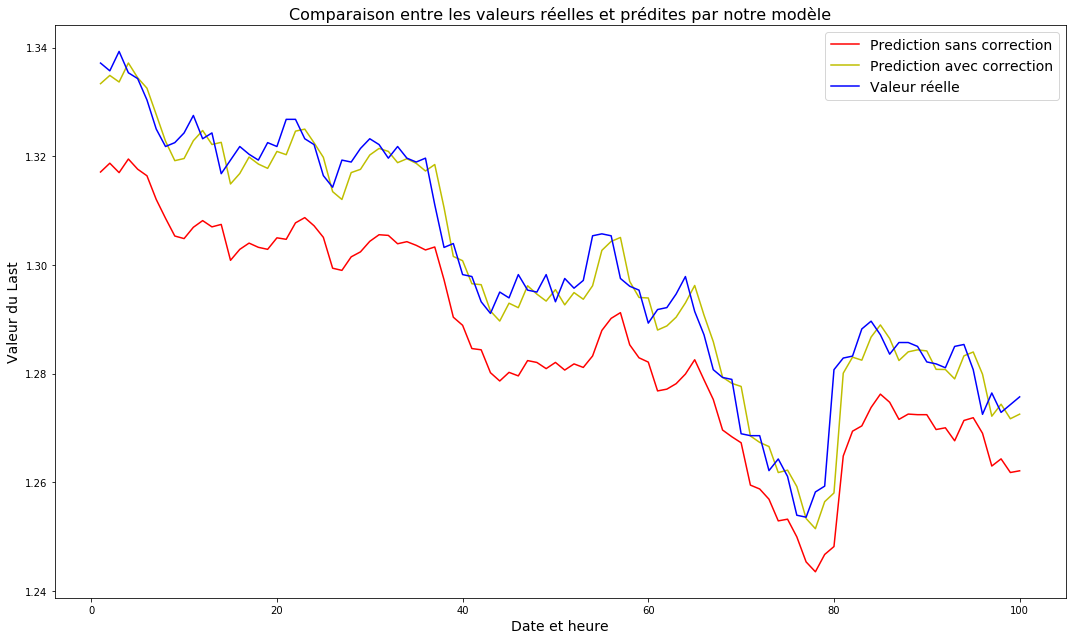

In [43]:
tracer_prediction_err(100, pred, corr, reel)


In [44]:
#Calcul de la RMSE
rmse = sqrt(mean_squared_error(corr, reel))
rmse = rmse/len(reel)
rmse

2.3437626755112205e-06

In [45]:
def classification_err (corr, dataframe):
    n_test = dataframe.shape[0]
    Y_hat = []
    for i in range (1,n_test) : 
        if dataframe.iloc[i,9]<dataframe.iloc[i-1,9]:
            Y_hat.append(-1)
        if dataframe.iloc[i,9]==dataframe.iloc[i-1,9]:
            Y_hat.append(0)
        if dataframe.iloc[i,9]>dataframe.iloc[i-1,9]:
            Y_hat.append(1) 
    l = len(Y_hat)
    print("La longueur de la liste des labels prédit est : %s" %l)
    print("La longueur du dataframe est : %s" %n_test)
    dataframe = dataframe.iloc[1:,:]
    n_test=dataframe.shape[0]
    print()
    print("La longueur de la liste des labels est : %s" %l)
    print("La longueur du dataframe privé de sa première ligne est : %s" %n_test)
    dataframe.insert(10,'Y_hat',Y_hat)
    return (dataframe)

In [46]:
data_classif = classification_err (corr, df_prediction_err_test)

La longueur de la liste des labels prédit est : 2014
La longueur du dataframe est : 2015

La longueur de la liste des labels est : 2014
La longueur du dataframe privé de sa première ligne est : 2014


In [47]:
data_classif

,Open,High,Low,Spread,Last,Y,Last_hat_norm,err,err_hat,Last_hat_corr,Y_hat
4038,1.337621,1.327305,1.332035,0.064815,1.335714,1,1.318713,0.017001,0.016155,1.334868,1
4039,1.335834,1.328723,1.334513,0.050926,1.339286,-1,1.316980,0.022306,0.016680,1.333660,-1
4040,1.339050,1.329433,1.334159,0.064815,1.335357,1,1.319484,0.015874,0.017674,1.337158,1
4041,1.335834,1.326241,1.331681,0.055556,1.334286,-1,1.317611,0.016675,0.016830,1.334441,-1
4042,1.334405,1.324113,1.323894,0.129630,1.330357,1,1.316402,0.013955,0.016116,1.332518,-1
...,...,...,...,...,...,...,...,...,...,...,...
6047,1.524830,1.514539,1.521416,0.032407,1.525357,-1,1.476221,0.049136,0.045336,1.521557,1
6048,1.525188,1.518085,1.522478,0.064815,1.527500,1,1.475992,0.051508,0.047137,1.523129,1
6049,1.527688,1.517730,1.524248,0.037037,1.529286,-1,1.477197,0.052088,0.048641,1.525838,1
6050,1.529475,1.517730,1.524602,0.032407,1.529286,-1,1.478673,0.050613,0.048880,1.527553,1


In [56]:
def calcul_erreur_classif (df_err):
    s = 0
    n = df_err.shape[0]
    for i in range (0,n):
        if df_err.iloc[i,5] != df_err.iloc[i,10]:
            s+=1
    erreur = s/n
    return(erreur)

In [57]:
erreur = calcul_erreur_classif(data_classif)
erreur

0.5253227408142999